In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [2]:
df = pd.read_csv("data/stud_cleaned.csv")

In [3]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,total_score,average
0,female,group B,bachelor's degree,standard,none,72,72,74,218,72.67
1,female,group C,some college,standard,completed,69,90,88,247,82.33
2,female,group B,master's degree,standard,none,90,95,93,278,92.67
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,49.33
4,male,group C,some college,standard,none,76,78,75,229,76.33


## Prepare Data

In [ ]:
X = df.drop(columns=["total_score"], axis=1)
y = df["total_score"]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       1000 non-null   object 
 1   race_ethnicity               1000 non-null   object 
 2   parental_level_of_education  1000 non-null   object 
 3   lunch                        1000 non-null   object 
 4   test_preparation_course      1000 non-null   object 
 5   math_score                   1000 non-null   int64  
 6   reading_score                1000 non-null   int64  
 7   writing_score                1000 non-null   int64  
 8   total_score                  1000 non-null   int64  
 9   average                      1000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 78.3+ KB


In [6]:
# Build a pipeline to preprocess the data
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

num_transformer = StandardScaler()
ohe_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", ohe_transformer, cat_features),
        ("StandardScaler", num_transformer, num_features),        
    ]
)

In [7]:
X = preprocessor.fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Train set shape: (800, 21), Test set shape: (200, 21)


In [9]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [15]:
# Models to be evaluated.
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

# Scoring metrics for cross validation.
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}

# Number of folds for cross validation.
cv_folds = 5

# Container for all the results.
results = []

for model_name, model in models.items():
    print(f"Evaluating model: {model_name}")
    
    # Perform cross validation on the training set.
    cv_results = cross_validate(
        model, X_train, y_train, cv=cv_folds, scoring=scoring, return_train_score=True
    )
    
    # Average metrics across folds for training and validation sets.
    train_mae = -np.mean(cv_results['train_MAE'])
    train_rmse = np.sqrt(-np.mean(cv_results['train_MSE']))
    train_r2 = np.mean(cv_results['train_R2'])
    
    valid_mae = -np.mean(cv_results['test_MAE'])
    valid_rmse = np.sqrt(-np.mean(cv_results['test_MSE']))
    valid_r2 = np.mean(cv_results['test_R2'])
    
    print("Cross-Validation Performance on Training Folds:")
    print(f"Mean Absolute Error: {train_mae:.4f}")
    print(f"Root Mean Squared Error: {train_rmse:.4f}")
    print(f"R2 Score: {train_r2:.4f}")
    
    print("Cross-Validation Performance on Validation Folds:")
    print(f"Mean Absolute Error: {valid_mae:.4f}")
    print(f"Root Mean Squared Error: {valid_rmse:.4f}")
    print(f"R2 Score: {valid_r2:.4f}")
    
    # Fit the model on the entire training set and evaluate on the test set.
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)
    
    print("Final Evaluation on Test Set:")
    print(f"Mean Absolute Error: {test_mae:.4f}")
    print(f"Root Mean Squared Error: {test_rmse:.4f}")
    print(f"R2 Score: {test_r2:.4f}")
    print("="*50, "\n")
    
    # Store results in a dictionary.
    results.append({
        "Model": model_name,
        "Train MAE": train_mae,
        "Train RMSE": train_rmse,
        "Train R2": train_r2,
        "CV Valid MAE": valid_mae,
        "CV Valid RMSE": valid_rmse,
        "CV Valid R2": valid_r2,
        "Test MAE": test_mae,
        "Test RMSE": test_rmse,
        "Test R2": test_r2
    })

Evaluating model: Linear Regression
Cross-Validation Performance on Training Folds:
Mean Absolute Error: 0.0000
Root Mean Squared Error: 0.0000
R2 Score: 1.0000
Cross-Validation Performance on Validation Folds:
Mean Absolute Error: 0.0000
Root Mean Squared Error: 0.0000
R2 Score: 1.0000
Final Evaluation on Test Set:
Mean Absolute Error: 0.0000
Root Mean Squared Error: 0.0000
R2 Score: 1.0000

Evaluating model: Lasso
Cross-Validation Performance on Training Folds:
Mean Absolute Error: 0.8081
Root Mean Squared Error: 1.0095
R2 Score: 0.9994
Cross-Validation Performance on Validation Folds:
Mean Absolute Error: 0.8101
Root Mean Squared Error: 1.0138
R2 Score: 0.9994
Final Evaluation on Test Set:
Mean Absolute Error: 0.8310
Root Mean Squared Error: 1.0553
R2 Score: 0.9994

Evaluating model: Ridge
Cross-Validation Performance on Training Folds:
Mean Absolute Error: 0.0179
Root Mean Squared Error: 0.0221
R2 Score: 1.0000
Cross-Validation Performance on Validation Folds:
Mean Absolute Error: 

In [16]:
# Create a DataFrame to display the results.
results_df = pd.DataFrame(results, 
                          columns=[
                              "Model",
                              "Train MAE",
                              "Train RMSE",
                              "Train R2",
                              "CV Valid MAE",
                              "CV Valid RMSE",
                              "CV Valid R2",
                              "Test MAE",
                              "Test RMSE",
                              "Test R2"
                              ]
                          ).round(4).set_index("Model").sort_values(ascending=False, by="Test R2")
results_df

,Train MAE,Train RMSE,Train R2,CV Valid MAE,CV Valid RMSE,CV Valid R2,Test MAE,Test RMSE,Test R2
Model,,,,,,,,,
Linear Regression,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
Ridge,0.0179,0.0221,1.0000,0.0183,0.0226,1.0000,0.0145,0.0193,1.0000
Lasso,0.8081,1.0095,0.9994,0.8101,1.0138,0.9994,0.8310,1.0553,0.9994
XGBRegressor,0.0232,0.0329,1.0000,0.5214,1.4875,0.9988,0.5282,2.2272,0.9974
Random Forest Regressor,0.0974,0.4394,0.9999,0.2562,1.0343,0.9994,0.3438,2.7460,0.9961
CatBoosting Regressor,0.2836,0.3513,0.9999,0.8207,1.6471,0.9985,0.9448,3.1184,0.9950
AdaBoost Regressor,2.3684,3.0157,0.9949,2.4385,3.2632,0.9940,2.0386,3.7522,0.9927
K-Neighbors Regressor,4.6324,5.9454,0.9803,5.5142,7.1017,0.9719,5.7690,7.9983,0.9668


The results in the DataFrame indicate the following:

1. **Linear Regression and Ridge:**  
   - Both models report **perfect scores** (Train R², CV Valid R², and Test R² equal to 1.0000 with zero errors).  
   - This suggests that the relationship between the predictors and the target variable is likely linear and that these models capture it perfectly.  
   - It may also imply that the dataset is either very clean or potentially synthetic, where the target is a near‐perfect linear function of the inputs.

2. **Lasso Regression:**  
   - Lasso’s performance is almost identical to Linear Regression and Ridge, with very slight deviations (R² of 0.9994 and marginally higher errors).  
   - The small differences could be due to the L1 regularization effect, which might be zeroing out some coefficients when they are not strictly needed.

3. **XGBRegressor, Random Forest, and CatBoosting Regressor:**  
   - These models have higher training errors than the linear models and noticeably higher errors in the cross‑validation and test sets.  
   - For instance, XGBRegressor shows a jump from a train RMSE of 0.0329 to a CV Valid RMSE of 1.4875 and a Test RMSE of 2.2272, with the corresponding R² dropping slightly below 1.
   - This pattern suggests that while these models are flexible, they might be **overfitting** to the training data or not as well‐tuned for this problem.

4. **AdaBoost and K-Neighbors Regressor:**  
   - Both show significantly higher errors across all metrics.  
   - K-Neighbors Regressor, for example, has a Test R² of 0.9668 and the highest errors among the listed models.
   - These results indicate that these models are not as well-suited for the underlying structure of the data as the linear or some ensemble methods in this case.

---

### How to Improve the Model

Even though the simpler models (Linear Regression, Ridge, and Lasso) perform exceptionally well, we need to consider the following steps to improve or validate the robustness of the model further:

1. **Data Examination and Preprocessing:**
   - **Investigate Data Quality:** Ensure that the data is free from errors, and confirm if the near-perfect performance is realistic or a sign of a synthetic/simplified dataset.
   - **Feature Engineering:** Evaluate whether additional or transformed features could capture more complex patterns if the problem is more nuanced than it appears.
   - **Outlier Analysis:** Verify that outliers are not unduly influencing model performance.

2. **Hyperparameter Tuning for Complex Models:**
   - For models like XGBRegressor, Random Forest, CatBoost, and AdaBoost, we can perform a more rigorous hyperparameter tuning (using Grid Search or Random Search) to adjust parameters such as:
     - **For tree-based models:** Number of estimators, maximum depth, minimum samples split, learning rate (for boosting methods), etc.
     - **For K-Neighbors:** The number of neighbors and the distance metric.
   - Better tuning might reduce the gap between training and validation/test performance and mitigate overfitting.

3. **Regularization and Model Complexity:**
   - For models that show signs of overfitting (like XGBRegressor in this case), consider:
     - **Regularization parameters:** Increase regularization (e.g., setting a higher minimum child weight or reducing the maximum depth in tree-based models).
     - **Pruning:** Implement techniques to prune overly complex models.
  
4. **Advanced Validation Techniques:**
   - **Nested Cross Validation:** Use nested cross validation to better estimate model performance and hyperparameter tuning effects.

5. **Model Selection Based on Problem Complexity:**
   - If the relationship in the data is truly linear, the simpler models (Linear Regression, Ridge, Lasso) are likely the best choice.
   - For real-world scenarios where non-linearity might exist, we should consider ensemble methods and then refine them with hyperparameter tuning and feature selection.

6. **Ensemble Methods and Stacking:**
   - If we suspect that different models capture different aspects of the data, you might explore stacking or blending methods to combine the strengths of multiple models.

---

### Final Considerations

- **Validation of Results:**  
  Before further tuning, validate that the near-perfect scores from linear models are not due to data leakage or overly simplistic data.  
- **Complexity vs. Interpretability:**  
  Given that simpler models perform perfectly, they also offer greater interpretability. Only opt for more complex models if there is clear evidence of non-linearity or if additional domain insights require them.

By following these steps, we can ensure that the model is both robust and well-suited to the underlying structure of the data.

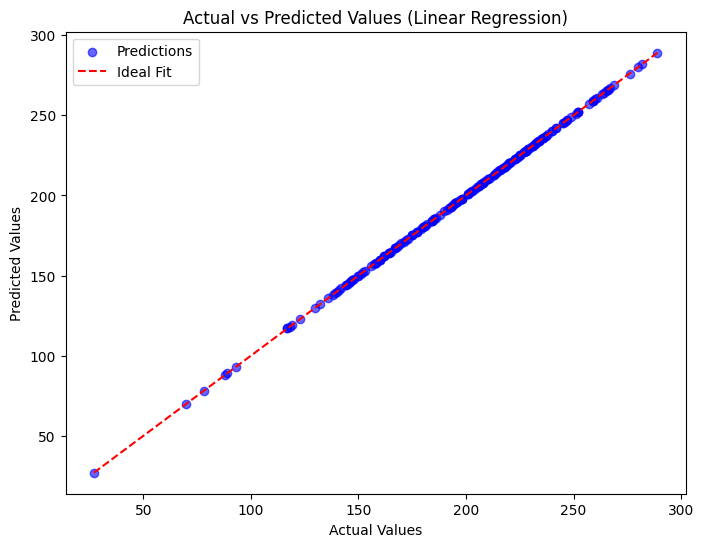

In [ ]:
best_model = models["Linear Regression"]

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values (Linear Regression)")
plt.legend()
plt.show()